# We will analyze stocks using Markowitz portfolio theory

As data for analysis we will use data on 55 stocks traded on the Moscow Exchange
The input data for each stock will be historical data for the stock since January 1, 2022 and forecast data for two weeks, plotted as in https://github.com/SamoilovSD/ETF/blob/main/etf_try.ipynb.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import os
from tqdm import tqdm
from sklearn.linear_model import LinearRegression

from datetime import datetime
import datetime 

rc = {"font.family" : "serif", 
      "mathtext.fontset" : "stix"}
plt.rcParams.update(rc)
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]
matplotlib.rcParams.update({'font.size': 12})

In [2]:
dateparse = lambda x: datetime.datetime.strptime(x, '%d.%m.%Y')

In [3]:
today_str = str(datetime.datetime.today())[0:10].replace('-','_')

Date when the forecast was made

In [4]:
date_of_analysis = '2023_09_02'

In [5]:
start_str = 'D:/Desktop/Работа/etf_funds/data_hist/'+ date_of_analysis +'/'
save_path = 'D:/Desktop/Работа/etf_funds/result_hist/'+ date_of_analysis +'/'

In [6]:
df = pd.read_excel(save_path+'resulted_{}.xlsx'.format(date_of_analysis))
df

,bond_name,earn_high_p,earn_med_p,earn_low_p
0,AQUA,27.62,24.31,21.13
1,MRKZ,21.74,21.74,13.04
2,ARSA,16.43,12.82,8.87
3,MDMG,14.77,12.62,10.47
4,ELFV,12.53,9.97,6.14
5,MRKC,10.85,9.20,7.54
6,MRKY,19.44,8.58,8.58
7,GEMC,10.25,7.36,4.25
8,RENI,11.58,6.53,1.48
9,SELG,10.65,6.29,1.84


In [7]:
amount_of_predicted_days = 14

In [8]:
amount_of_weekdays = int(amount_of_predicted_days/7*2)

In [9]:
list_of_bonds = df.bond_name.values

## Calculation of return and volatility of each stock. As well as beta and Sharpe ratios for historical, forecast and full datasets

In [10]:
list_ETF_names = np.array([])

list_mean_history = np.array([])
list_std_history = np.array([])
list_mean_forecast = np.array([])
list_std_forecast = np.array([])
list_mean_full = np.array([])
list_std_full = np.array([])

list_coef_sharp_history = np.array([])
list_coef_sharp_forecast = np.array([])
list_coef_sharp_full = np.array([])

list_coef_trein_history = np.array([])
list_coef_trein_forecast = np.array([])
list_coef_trein_full = np.array([])

list_beta_history = np.array([])
list_beta_forecast = np.array([])
list_beta_full = np.array([])


for ETF_name in tqdm(list_of_bonds):
    df_orig = pd.read_csv('D:/Desktop/Работа/etf_funds/data_hist/{}/{}.csv'.format(date_of_analysis, ETF_name), 
                   parse_dates=['date'], date_parser=dateparse,
                   names=['date', 'price', 'price_open', 'price_max', 'price_min', 'vol', 'change_perc'], 
                   skiprows=1,  thousands = '.', decimal=",")
    df_orig = df_orig[['date', 'price']]
    new_date = pd.to_datetime(df_orig['date'],  format='%d.%m.%Y')
    df_orig['date'] = new_date

    dfn = df_orig.set_index('date').resample('D').asfreq()
    dfn['Day'] = dfn.index.strftime('%A')
    cond = dfn['Day'].isin(['Saturday', 'Sunday'])
    dfn = dfn[~cond].fillna(method='ffill').reset_index()
    df_orig = dfn.sort_values('date', ascending=True).reset_index(drop=True)
    df_orig = df_orig[['date', 'price']]
    
    df_forecast = pd.read_excel('D:/Desktop/Работа/etf_funds/result_hist/{}/{}/{}_{}.xlsx'.format(date_of_analysis,ETF_name,ETF_name,date_of_analysis), 
        thousands = '.', decimal=",")
    df_forecast = df_forecast[['date','price']]
    
    df_full = pd.concat([df_orig, df_forecast]).reset_index(drop=True)
    
    list_prices = np.array([])
    for row in df_full.itertuples():
        list_prices = np.append(list_prices, row[2])

    list_earnings = np.array([np.nan])
    for i in range(1,len(list_prices)):
        list_earnings = np.append(list_earnings, np.log(list_prices[i]/list_prices[i-1]))
    df_full['earnings'] = list_earnings
    df_full = df_full.dropna()
    
    mean_forecast = df_full[-amount_of_predicted_days+amount_of_weekdays:].earnings.mean()*252
    std_forecast = df_full[-amount_of_predicted_days+amount_of_weekdays:].earnings.std() * 252**(1/2)
    
    mean_history = df_full[:-amount_of_predicted_days+amount_of_weekdays].earnings.mean()*252
    std_history = df_full[:-amount_of_predicted_days+amount_of_weekdays].earnings.std() * 252**(1/2)
    
    mean_full = df_full.earnings.mean()*252
    std_full = df_full.earnings.std() * 252**(1/2)
    
    coef_sharp_history = mean_history/std_history
    coef_sharp_forecast = mean_forecast/std_forecast
    coef_sharp_full = mean_full/std_full
    
    df_MMVB_orig = pd.read_csv('D:/Desktop/Работа/etf_funds/data_hist/{}/ММВБ.csv'.format(date_of_analysis), 
                   parse_dates=['date'], date_parser=dateparse,
                   names=['date', 'price', 'price_open', 'price_max', 'price_min', 'vol', 'change_perc'], 
                   skiprows=1,  thousands = '.', decimal=",")
    df_MMVB_orig = df_MMVB_orig[['date', 'price']]
    new_date = pd.to_datetime(df_MMVB_orig['date'],  format='%d.%m.%Y')
    df_MMVB_orig['date'] = new_date

    dfn = df_MMVB_orig.set_index('date').resample('D').asfreq()
    dfn['Day'] = dfn.index.strftime('%A')
    cond = dfn['Day'].isin(['Saturday', 'Sunday'])
    dfn = dfn[~cond].fillna(method='ffill').reset_index()
    df_MMVB_orig = dfn.sort_values('date', ascending=True).reset_index(drop=True)
    df_MMVB_orig = df_MMVB_orig[['date', 'price']]
    df_MMVB_orig = df_MMVB_orig.query('date >= "{}"'.format(df_full.iloc[0].date-datetime.timedelta(days=1)))
    
    df_MMVB_forecast = pd.read_excel('D:/Desktop/Работа/etf_funds/result_hist/{}/ММВБ/ММВБ_{}.xlsx'.format(date_of_analysis,date_of_analysis), 
        thousands = '.', decimal=",")
    df_MMVB_forecast = df_MMVB_forecast[['date','price']]
    
    df_MMVB_full = pd.concat([df_MMVB_orig, df_MMVB_forecast]).reset_index(drop=True)
    
    list_prices = np.array([])
    for row in df_MMVB_full.itertuples():
        list_prices = np.append(list_prices, row[2])

    list_earnings = np.array([np.nan])
    for i in range(1,len(list_prices)):
        list_earnings = np.append(list_earnings, np.log(list_prices[i]/list_prices[i-1]))
        
    df_MMVB_full['earnings'] = list_earnings
    df_MMVB_full = df_MMVB_full.dropna()
    
    beta_history = LinearRegression() \
    .fit(df_MMVB_full[:-amount_of_predicted_days+amount_of_weekdays].earnings.values.reshape((-1, 1)), 
    df_full[:-amount_of_predicted_days+amount_of_weekdays].earnings.values).coef_[0]
    
    beta_forecast = LinearRegression() \
    .fit(df_MMVB_full[-amount_of_predicted_days+amount_of_weekdays:].earnings.values.reshape((-1, 1)), 
    df_full[-amount_of_predicted_days+amount_of_weekdays:].earnings.values).coef_[0]
    
    beta_full = LinearRegression() \
    .fit(df_MMVB_full.earnings.values.reshape((-1, 1)), 
    df_full.earnings.values).coef_[0]
    
    coef_trein_history = mean_history/beta_history
    coef_trein_forecast = mean_forecast/beta_forecast
    coef_trein_full = mean_full/beta_full
    
    list_ETF_names = np.append(list_ETF_names, ETF_name)

    list_mean_history = np.append(list_mean_history, mean_history)
    list_std_history = np.append(list_std_history, std_history)
    list_mean_forecast = np.append(list_mean_forecast, mean_forecast)
    list_std_forecast = np.append(list_std_forecast, std_forecast)
    list_mean_full = np.append(list_mean_full, mean_full)
    list_std_full = np.append(list_std_full, std_full)

    list_coef_sharp_history = np.append(list_coef_sharp_history, coef_sharp_history)
    list_coef_sharp_forecast = np.append(list_coef_sharp_forecast, coef_sharp_forecast)
    list_coef_sharp_full = np.append(list_coef_sharp_full, coef_sharp_full)

    list_coef_trein_history = np.append(list_coef_trein_history, coef_trein_history)
    list_coef_trein_forecast = np.append(list_coef_trein_forecast, coef_trein_forecast)
    list_coef_trein_full = np.append(list_coef_trein_full, coef_trein_full)

    list_beta_history = np.append(list_beta_history, beta_history)
    list_beta_forecast = np.append(list_beta_forecast, beta_forecast)
    list_beta_full = np.append(list_beta_full, beta_full)

  0%|                                                                                           | 0/55 [00:00<?, ?it/s]C:\Users\User\AppData\Local\Temp\ipykernel_17564\1128022440.py:24: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_orig = pd.read_csv('D:/Desktop/Работа/etf_funds/data_hist/{}/{}.csv'.format(date_of_analysis, ETF_name),
C:\Users\User\AppData\Local\Temp\ipykernel_17564\1128022440.py:35: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  dfn = dfn[~cond].fillna(method='ffill').reset_index()
C:\Users\User\AppData\Local\Temp\ipykernel_17564\1128022440.py:68: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then 

In [11]:
df_res = pd.DataFrame({
    'bond_name':list_ETF_names,
    
    'mean_earn_history':list_mean_history,
    'std_earn_history':list_std_history,
    
    'mean_earn_forecast':list_mean_forecast,
    'std_earn_forecast':list_std_forecast,
    
    'mean_earn_full':list_mean_full,
    'std_earn_full':list_std_full,
    
    
    'coef_sharp_history':list_coef_sharp_history,
    'coef_sharp_forecast':list_coef_sharp_forecast,
    'coef_sharp_full':list_coef_sharp_full,
    
    'coef_trein_beta_history':list_coef_trein_history,
    'coef_trein_beta_forecast':list_coef_trein_forecast,
    'coef_trein_beta_full':list_coef_trein_full,
    
    'beta_history':list_beta_history,
    'beta_forecast':list_beta_forecast,
    'beta_full':list_beta_full
})
df_res = df.merge(df_res, on='bond_name', how='inner')
df_res = df_res.sort_values('earn_med_p', ascending=False)
df_res

,bond_name,earn_high_p,earn_med_p,earn_low_p,mean_earn_history,std_earn_history,mean_earn_forecast,std_earn_forecast,mean_earn_full,std_earn_full,coef_sharp_history,coef_sharp_forecast,coef_sharp_full,coef_trein_beta_history,coef_trein_beta_forecast,coef_trein_beta_full,beta_history,beta_forecast,beta_full
0,AQUA,27.62,24.31,21.13,0.437755,0.215898,11.118733,0.867415,1.037810,0.326154,2.027603,12.818233,3.181961,0.792497,-11.905313,1.717844,0.552374,-0.933930,0.604135
1,MRKZ,21.74,21.74,13.04,1.486255,0.478890,17.359540,1.818674,2.378012,0.661722,3.103539,9.545165,3.593674,1.504615,-2.638815,2.365061,0.987797,-6.578536,1.005476
2,ARSA,16.43,12.82,8.87,1.362436,0.418167,2.466137,0.416899,1.424442,0.417229,3.258114,5.915425,3.414055,3.298696,0.765824,3.169699,0.413023,3.220241,0.449393
3,MDMG,14.77,12.62,10.47,0.880948,0.313914,6.850787,0.611084,1.216332,0.345692,2.806339,11.210878,3.518539,0.945060,1.410353,1.203426,0.932160,4.857497,1.010725
4,ELFV,12.53,9.97,6.14,0.302686,0.305572,5.368118,0.240600,0.587260,0.310599,0.990555,22.311353,1.890737,0.348354,3.763378,0.648957,0.868901,1.426409,0.904930
5,MRKC,10.85,9.20,7.54,0.757545,0.343140,5.642316,0.354049,1.031970,0.350022,2.207688,15.936529,2.948303,0.781953,-15.497797,1.050280,0.968786,-0.364072,0.982567
6,MRKY,19.44,8.58,8.58,1.028451,0.374757,10.356703,0.970706,1.552510,0.445907,2.744311,10.669247,3.481689,1.180551,-8.070209,1.714518,0.871162,-1.283325,0.905508
7,GEMC,10.25,7.36,4.25,1.457917,0.488078,4.009753,0.417585,1.601278,0.484774,2.987056,9.602240,3.303143,1.317951,0.795964,1.378371,1.106199,5.037608,1.161718
8,RENI,11.58,6.53,1.48,1.226759,0.370387,1.571670,0.291267,1.246136,0.365753,3.312099,5.395970,3.407047,1.434600,4.532858,1.468553,0.855123,0.346728,0.848547
9,SELG,10.65,6.29,1.84,0.953467,0.326562,2.139361,0.415798,1.020090,0.331220,2.919709,5.145197,3.079801,1.193518,0.431328,1.201362,0.798871,4.959938,0.849111


In [12]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

## Keeping only earning assets

In [13]:
df_qir = df_res.query('(mean_earn_history > 0) & (std_earn_history > 0)')

Volatility-return chart, the color palette shows the projected return for the next 2 weeks, made according to the method https://github.com/SamoilovSD/ETF/blob/main/etf_try.ipynb.

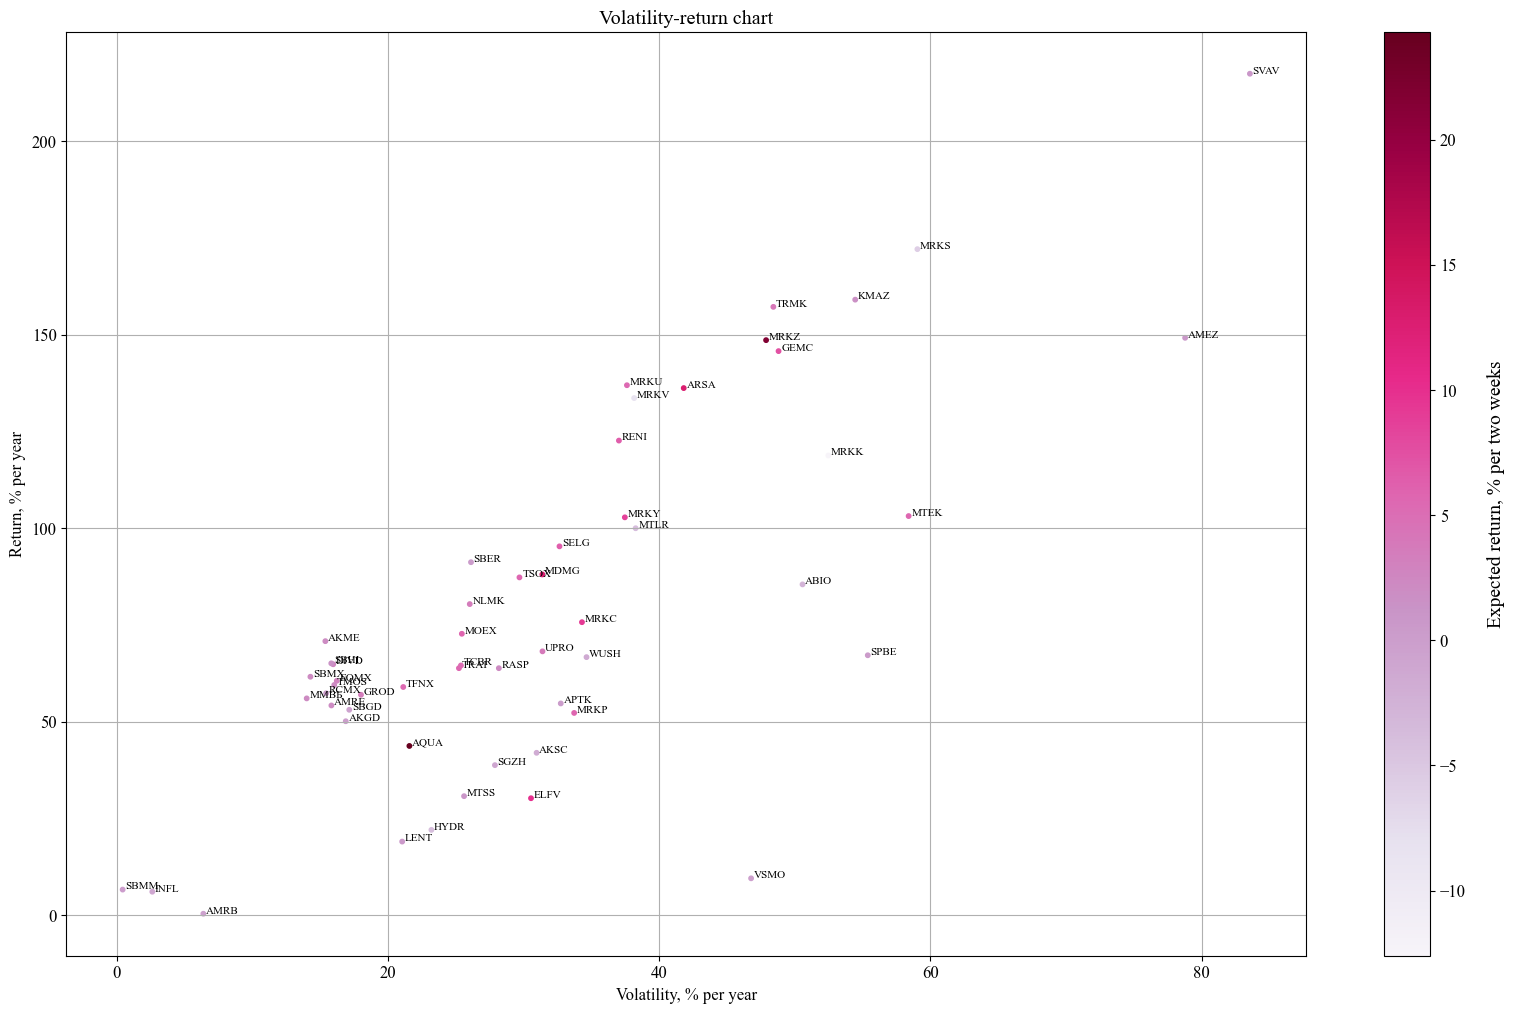

In [14]:
fig, ax = plt.subplots(figsize=(20,12))
ax.scatter(df_qir.std_earn_history*100, df_qir.mean_earn_history*100, c=df_qir.earn_med_p, cmap='PuRd', s=10)
ax.set_ylabel('Return, % per year')
ax.set_xlabel('Volatility, % per year')
ax.set_title('Volatility-return chart')
for idx, row in df_qir.iterrows():
    ax.annotate(row['bond_name'], (row['std_earn_history']*100+0.2, row['mean_earn_history']*100+0.2), fontsize=8) #row['bond_name']

    
    
norm = plt.Normalize(np.min(df_qir.earn_med_p), np.max(df_qir.earn_med_p))
smap = plt.cm.ScalarMappable(cmap='PuRd', norm=norm)
cbar = fig.colorbar(smap, ax=ax)
cbar.ax.tick_params(labelsize=12)
cbar.ax.set_ylabel('Expected return, % per two weeks', rotation=90, labelpad = 15, fontdict = {"size":14})
ax.grid()
plt.show()
fig.savefig('graph.png', dpi=1500)

Final dataframe

In [15]:
df_res[['bond_name', 'earn_high_p', 'earn_med_p', 'earn_low_p', 'coef_sharp_history', 'coef_sharp_full']].sort_values('earn_med_p', ascending=False)

,bond_name,earn_high_p,earn_med_p,earn_low_p,coef_sharp_history,coef_sharp_full
0,AQUA,27.62,24.31,21.13,2.027603,3.181961
1,MRKZ,21.74,21.74,13.04,3.103539,3.593674
2,ARSA,16.43,12.82,8.87,3.258114,3.414055
3,MDMG,14.77,12.62,10.47,2.806339,3.518539
4,ELFV,12.53,9.97,6.14,0.990555,1.890737
5,MRKC,10.85,9.20,7.54,2.207688,2.948303
6,MRKY,19.44,8.58,8.58,2.744311,3.481689
7,GEMC,10.25,7.36,4.25,2.987056,3.303143
8,RENI,11.58,6.53,1.48,3.312099,3.407047
9,SELG,10.65,6.29,1.84,2.919709,3.079801


A set of stocks with return, volatility and Sharpe ratio forecasted parameters differing by no more than 10% of historical data

Sorted by average expected returns

In [16]:
df_res.query('(coef_sharp_history >= coef_sharp_full*0.9) & (mean_earn_history >= mean_earn_full*0.9) & (std_earn_history >= std_earn_full*0.9)')

,bond_name,earn_high_p,earn_med_p,earn_low_p,mean_earn_history,std_earn_history,mean_earn_forecast,std_earn_forecast,mean_earn_full,std_earn_full,coef_sharp_history,coef_sharp_forecast,coef_sharp_full,coef_trein_beta_history,coef_trein_beta_forecast,coef_trein_beta_full,beta_history,beta_forecast,beta_full
2,ARSA,16.43,12.82,8.87,1.362436,0.418167,2.466137,0.416899,1.424442,0.417229,3.258114,5.915425,3.414055,3.298696,0.765824,3.169699,0.413023,3.220241,0.449393
7,GEMC,10.25,7.36,4.25,1.457917,0.488078,4.009753,0.417585,1.601278,0.484774,2.987056,9.602240,3.303143,1.317951,0.795964,1.378371,1.106199,5.037608,1.161718
8,RENI,11.58,6.53,1.48,1.226759,0.370387,1.571670,0.291267,1.246136,0.365753,3.312099,5.395970,3.407047,1.434600,4.532858,1.468553,0.855123,0.346728,0.848547
9,SELG,10.65,6.29,1.84,0.953467,0.326562,2.139361,0.415798,1.020090,0.331220,2.919709,5.145197,3.079801,1.193518,0.431328,1.201362,0.798871,4.959938,0.849111
15,MRKU,7.39,5.50,1.73,1.369795,0.376292,3.675467,0.472718,1.499327,0.382208,3.640243,7.775183,3.922798,1.637186,3.645720,1.762912,0.836676,1.008160,0.850483
18,TRMK,9.91,4.19,-1.67,1.572272,0.484248,2.817800,0.321770,1.642246,0.476278,3.246830,8.757187,3.448081,1.509270,1.844763,1.562199,1.041743,1.527459,1.051240
49,NLMK,9.54,3.57,-2.70,0.804314,0.260416,1.709214,0.229704,0.855151,0.258537,3.088568,7.440927,3.307652,0.683474,0.743899,0.718318,1.176801,2.297643,1.190491
21,EQMX,7.05,2.95,-1.09,0.606017,0.162354,1.347056,0.079925,0.647649,0.159093,3.732695,16.853962,4.070881,0.623355,1.125821,0.663725,0.972187,1.196509,0.975778
22,DIVD,7.09,2.60,-1.93,0.648834,0.159715,1.455625,0.078442,0.694159,0.156583,4.062446,18.556816,4.433163,0.817149,1.734340,0.871217,0.794022,0.839296,0.796770
23,ММВБ,5.51,2.25,-1.42,0.560648,0.140190,1.144717,0.063631,0.593461,0.137189,3.999208,17.989944,4.325857,0.560648,1.144717,0.593461,1.000000,1.000000,1.000000
